<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/DM_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Latar Belakang**

#**1. Data Collection**

###**1.1 Import Drive**

In [1]:
# 1.1 Mount Google Drive (jika menggunakan Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**1.2 Import Library & Dataset**

In [2]:
# 1.2 Import library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/DM/salaries.csv')

##**1.3 Cek Awal Data**

In [3]:
# 1.3 Cek ukuran dan tampilkan 5 baris pertama
print("Jumlah baris & kolom:", df.shape)

Jumlah baris & kolom: (141566, 11)


In [4]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


##**1.4 Deskripsi Kolom**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141566 entries, 0 to 141565
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           141566 non-null  int64 
 1   experience_level    141566 non-null  object
 2   employment_type     141566 non-null  object
 3   job_title           141566 non-null  object
 4   salary              141566 non-null  int64 
 5   salary_currency     141566 non-null  object
 6   salary_in_usd       141566 non-null  int64 
 7   employee_residence  141566 non-null  object
 8   remote_ratio        141566 non-null  int64 
 9   company_location    141566 non-null  object
 10  company_size        141566 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.9+ MB


#**2. Pre Processing**

##**2.1 Cek Missing Value**

In [6]:
# Cek missing values
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


##**2.2 Cek Tipe Data Tiap Kolom**

In [7]:
df.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


##**2.3 Transformasi**

In [8]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')
df = df.dropna(subset=['salary_in_usd']).reset_index(drop=True)

#**3. Feature Engineering**

###**3.1 Konversi Kode Negara**

In [9]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.4 MB/s eta 0:00:00


In [10]:
import pycountry

# Fungsi untuk mengubah kode negara jadi nama lengkap
def convert_country(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code  # Kalau gagal, kembalikan kode aslinya

# Tambahkan kolom baru 'country_name'
df['country_name'] = df['company_location'].apply(convert_country)

In [11]:
# Gabungkan job_title dan lokasi perusahaan
df['job_loc'] = df['job_title'] + "_" + df['company_location']

# Tambahkan region (Asia, EMEA, Americas)
asia = ['ID', 'SG', 'MY', 'PH', 'TH', 'VN']
emea = ['GB', 'DE', 'FR', 'NG', 'KE']
americas = ['US', 'CA', 'BR', 'MX']

def map_region(code):
    if code in asia:
        return 'Asia'
    elif code in emea:
        return 'EMEA'
    elif code in americas:
        return 'Americas'
    else:
        return 'Other'

df['region'] = df['company_location'].map(map_region)

###**3.2 Target Label**

In [12]:
# Buat label target berdasarkan distribusi gaji
df['salary_level'] = pd.qcut(df['salary_in_usd'], q=3, labels=['low', 'medium', 'high'])

# Tampilkan distribusinya
print(df['salary_level'].value_counts())

salary_level
low       48635
high      46958
medium    45973
Name: count, dtype: int64


#**4. Feature Engineering**

In [13]:
# Copy dataset
df_model = df.copy()

# Ubah target ke bentuk angka manual (low=0, medium=1, high=2)
salary_map = {'low': 0, 'medium': 1, 'high': 2}
df_model['salary_level_enc'] = df_model['salary_level'].map(salary_map)

# Drop kolom target asli
df_model = df_model.drop(columns=['salary_level'])

# One-hot encoding fitur kategorikal
categorical_cols = ['job_title', 'company_location', 'employment_type',
                    'experience_level', 'company_size', 'remote_ratio']

df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

#**5. Train Test Split**

In [14]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['salary_level_enc', 'salary_currency', 'employee_residence', 'country_name', 'job_loc', 'region', 'salary', 'salary_in_usd'])
y = df_model['salary_level_enc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (113252, 515)
Test shape: (28314, 515)


#**6. Model Training**

###**5.1 Randomized Search CV**

###**5.2 Training Random Forest**

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

###**5.3 Training Decision Tree**

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

#**7. Evaluasi**

###**7.1 Evaluasi Random Forest**

In [21]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=list(salary_map.keys())))

Random Forest Accuracy: 0.5293141202232111
              precision    recall  f1-score   support

         low       0.63      0.61      0.62      9727
      medium       0.40      0.28      0.33      9195
        high       0.52      0.69      0.59      9392

    accuracy                           0.53     28314
   macro avg       0.52      0.53      0.51     28314
weighted avg       0.52      0.53      0.52     28314



###**7.2 Evaluasi Decision Tree**

In [22]:
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, target_names=list(salary_map.keys())))

Decision Tree Accuracy: 0.5276894822349368
              precision    recall  f1-score   support

         low       0.63      0.61      0.62      9727
      medium       0.39      0.30      0.34      9195
        high       0.53      0.67      0.59      9392

    accuracy                           0.53     28314
   macro avg       0.52      0.53      0.52     28314
weighted avg       0.52      0.53      0.52     28314



#**8. Cross Validation**

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Scorer untuk F1-macro
f1_macro = make_scorer(f1_score, average='macro')

# === Random Forest ===
rf_acc_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("RF CV Accuracy   : %.4f ± %.4f" % (rf_acc_scores.mean(), rf_acc_scores.std()))

rf_f1_scores = cross_val_score(rf, X, y, cv=5, scoring=f1_macro)
print("RF CV F1-macro   : %.4f ± %.4f" % (rf_f1_scores.mean(), rf_f1_scores.std()))

# === Decision Tree ===
dt_acc_scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
print("DT CV Accuracy   : %.4f ± %.4f" % (dt_acc_scores.mean(), dt_acc_scores.std()))

dt_f1_scores = cross_val_score(dt_model, X, y, cv=5, scoring=f1_macro)
print("DT CV F1-macro   : %.4f ± %.4f" % (dt_f1_scores.mean(), dt_f1_scores.std()))

RF CV Accuracy   : 0.5300 ± 0.0068
RF CV F1-macro   : 0.5157 ± 0.0080
DT CV Accuracy   : 0.5254 ± 0.0057
DT CV F1-macro   : 0.5136 ± 0.0072


#**9. Visualisasi**

###**9.1 Confussion Matrix Random Forest**

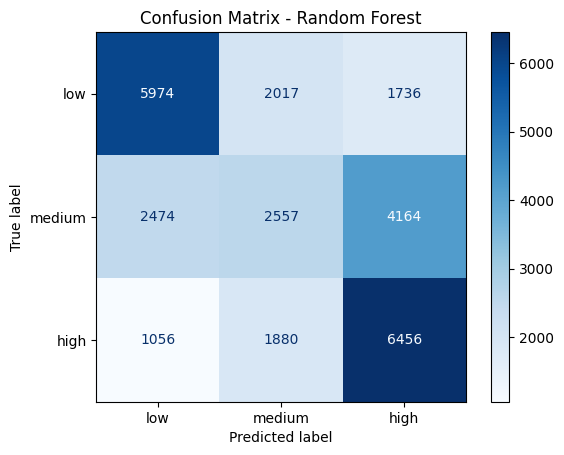

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=list(salary_map.keys()), cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

###**9.2 Confussion Matrix Decision Tree**

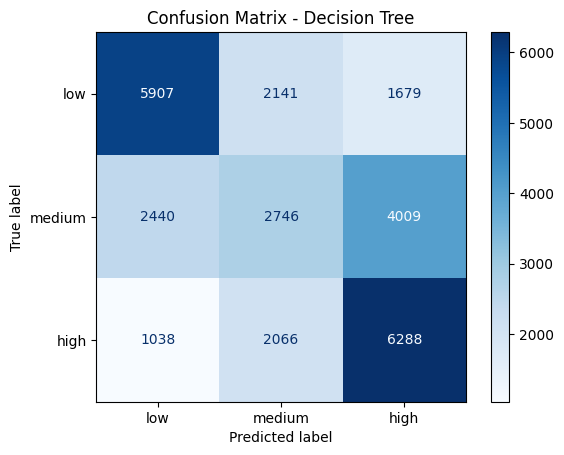

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, display_labels=list(salary_map.keys()), cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

###**9.3 Feature Importance Random Forest**

/tmp/ipython-input-29-3935336435.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp_rf.values, y=feat_imp_rf.index, palette='viridis')


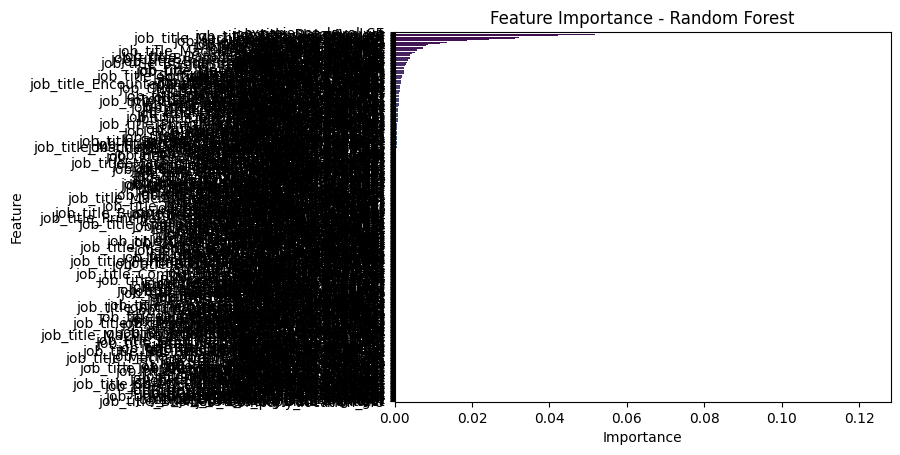

In [29]:
# Random Forest
feat_imp_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp_rf.values, y=feat_imp_rf.index, palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

###**9.4 Feature Importance Decision Tree**

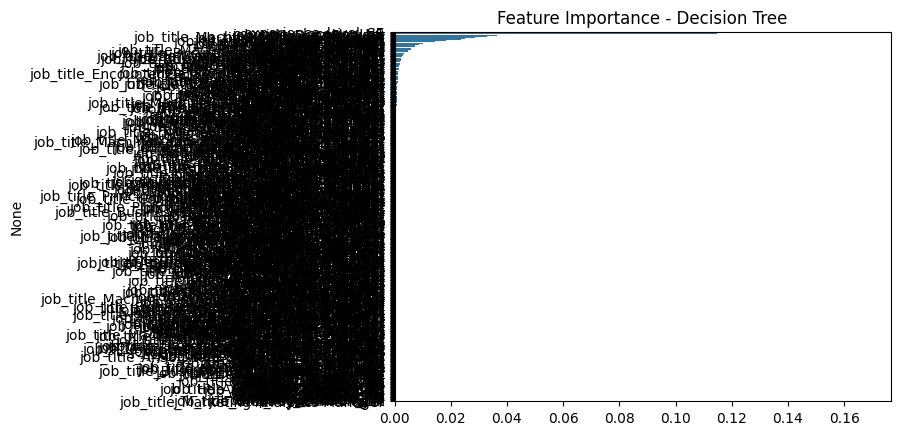

In [30]:
# Decision Tree
feat_imp_dt = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp_dt.values, y=feat_imp_dt.index)
plt.title("Feature Importance - Decision Tree")
plt.show()

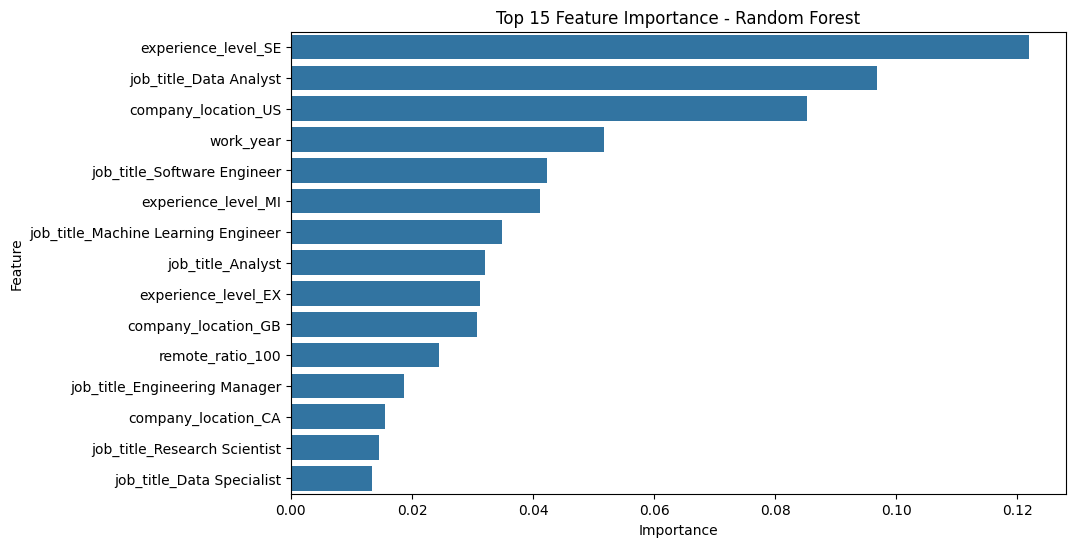

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Top 15 Feature Importance - Random Forest")
plt.show()

#**10. Kesimpulan**